<a href="https://colab.research.google.com/github/hal-29/CNN_with_SVM/blob/main/cnn_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %pip install torch torchvision scikit-learn matplotlib seaborn pandas joblib

In [ ]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

In [ ]:
# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 6
LR = 1e-3
FEATURE_DIM = 128

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=(device.type=="cuda"))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=(device.type=="cuda"))

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 472kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.81MB/s]

Train samples: 60000, Test samples: 10000


In [ ]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=FEATURE_DIM):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, feature_dim)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class CNNWithSoftmax(nn.Module):
    def __init__(self, feature_dim=FEATURE_DIM, n_classes=10):
        super().__init__()
        self.feature_extractor = CNNFeatureExtractor(feature_dim)
        self.classifier = nn.Linear(feature_dim, n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [ ]:
def train_cnn(model, loader, epochs=EPOCHS, lr=LR):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start = time.time()
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch {epoch}/{epochs} - Loss: {running_loss/total:.4f}, Acc: {correct/total:.4f}, Time: {time.time()-start:.1f}s")
    return model

def evaluate_cnn(model, loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

def extract_features(model, loader):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            f = model(imgs)
            feats.append(f.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(feats), np.hstack(labels)

In [ ]:
cnn_soft = CNNWithSoftmax()
print("Training Pure CNN...")
cnn_soft = train_cnn(cnn_soft, train_loader)

y_true_soft, y_pred_soft = evaluate_cnn(cnn_soft, test_loader)
acc_soft = accuracy_score(y_true_soft, y_pred_soft)
print(f"Pure CNN Test Accuracy: {acc_soft:.4f}")

# Save feature extractor
os.makedirs("models", exist_ok=True)
torch.save(cnn_soft.feature_extractor.state_dict(), "models/cnn_feature_extractor.pth")

Training Pure CNN...
Epoch 1/6 - Loss: 0.1543, Acc: 0.9525, Time: 16.5s
Epoch 2/6 - Loss: 0.0485, Acc: 0.9849, Time: 12.3s
Epoch 3/6 - Loss: 0.0355, Acc: 0.9887, Time: 12.3s
Epoch 4/6 - Loss: 0.0282, Acc: 0.9914, Time: 13.9s
Epoch 5/6 - Loss: 0.0209, Acc: 0.9934, Time: 12.6s
Epoch 6/6 - Loss: 0.0184, Acc: 0.9941, Time: 12.4s
Pure CNN Test Accuracy: 0.9906


In [ ]:
fe = CNNFeatureExtractor()
fe.load_state_dict(torch.load("models/cnn_feature_extractor.pth", map_location=device))
fe = fe.to(device)

print("Extracting features for training set...")
train_feats, train_labels = extract_features(fe, train_loader)
print("Extracting features for test set...")
test_feats, test_labels = extract_features(fe, test_loader)

print("Training SVM on CNN features...")
svm_clf = SVC(kernel="linear", C=1.0, random_state=SEED)
svm_clf.fit(train_feats, train_labels)

y_pred_svm = svm_clf.predict(test_feats)
acc_svm = accuracy_score(test_labels, y_pred_svm)
print(f"CNN + SVM Test Accuracy: {acc_svm:.4f}")

# Save models
torch.save(cnn_soft.state_dict(), "models/pure_cnn_full.pth")
joblib.dump(svm_clf, "models/svm_clf.joblib")

Extracting features for training set...
Extracting features for test set...
Training SVM on CNN features...
CNN + SVM Test Accuracy: 0.9915


['models/svm_clf.joblib']

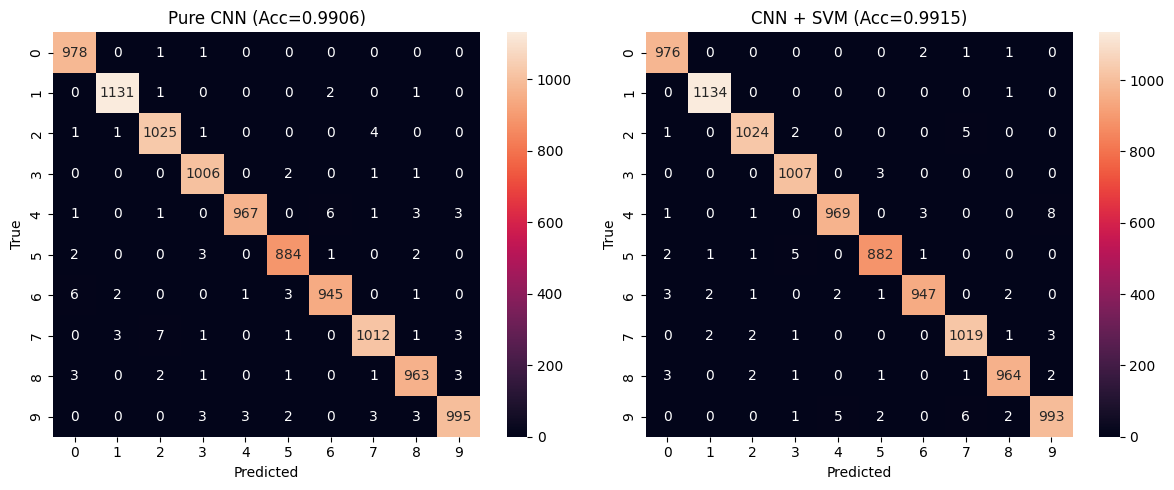

                Model  Test Accuracy
0  Pure CNN (Softmax)         0.9906
1           CNN + SVM         0.9915


In [ ]:
cm_soft = confusion_matrix(y_true_soft, y_pred_soft)
cm_svm = confusion_matrix(test_labels, y_pred_svm)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_soft, annot=True, fmt="d")
plt.title(f"Pure CNN (Acc={acc_soft:.4f})")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1,2,2)
sns.heatmap(cm_svm, annot=True, fmt="d")
plt.title(f"CNN + SVM (Acc={acc_svm:.4f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Results table
results_df = pd.DataFrame({
    "Model": ["Pure CNN (Softmax)", "CNN + SVM"],
    "Test Accuracy": [acc_soft, acc_svm]
})
print(results_df)

Running t-SNE on 2000 samples...


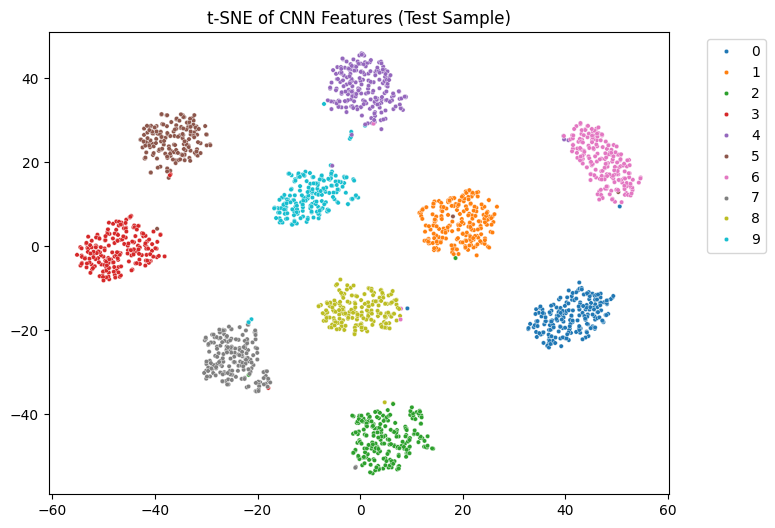

In [ ]:
SAMPLE_N = 2000
idx = np.random.choice(len(test_feats), size=min(SAMPLE_N, len(test_feats)), replace=False)
feats_sample = test_feats[idx]
labels_sample = test_labels[idx]

print(f"Running t-SNE on {len(idx)} samples...")
tsne = TSNE(n_components=2, random_state=SEED, init="pca", learning_rate="auto")
fe_tsne = tsne.fit_transform(feats_sample)

plt.figure(figsize=(8,6))
sns.scatterplot(x=fe_tsne[:,0], y=fe_tsne[:,1], hue=labels_sample, palette="tab10", s=10, legend="full")
plt.title("t-SNE of CNN Features (Test Sample)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()